## Data and Package Importing

Import the .py file with the QC class and function definitions

In [1]:
from QC import * 

Next, import the dataset for analysis. The QC preprocessing requires the data in three partitions.

1. Raw counts contained in a numpy.ndarray, as integers
2. Cell IDs in a 1-D numpy.ndarray, this can be barcodes or some other unique cell ID, with string datatype '<U16'
3. Gene IDs in a 1-D numpy.ndarray, these should be distinct gene names, with string datatype '<U16'

It also must be in a cell by gene, where each row represents a cell and each column represents a gene.

In [2]:
test_in=pd.read_csv("Example_dataset.csv",header=0,index_col=0) #
csr_counts=(test_in.values)
cellIDs=test_in.index.values.astype(str)
geneIDs=test_in.columns.values.astype(str)

## Library_data object initialization for inflection point calculation and downstream operations

First, we pass the data organized above into a library_data object.

In [3]:
test_lib=library_data(csr_counts,cellIDs,geneIDs,sort=True) #It is preferable to sort the library sizes as downstream processes depend on this ordering.

Now we calculate the possible inflection points. This is done by finding the maximum distance between the cumulative sum curve and the secant line. These distances are then assigned a percentile score. By default, the inflection points are returned based off of four percentiles, 0, 15, 30 and 100. 0 represent the absolute maximum value for the aformentioned distance. 

A 15-30th percentile inflection point as to capture more libraries in preprocessing, using the 0th precentile runs the risk of cutting out useful, though relatively lower quality libraries. 

Inflection point at [ 390  580  803 1999] for [0, 15, 30, 100] percentiles of greatest secant distances


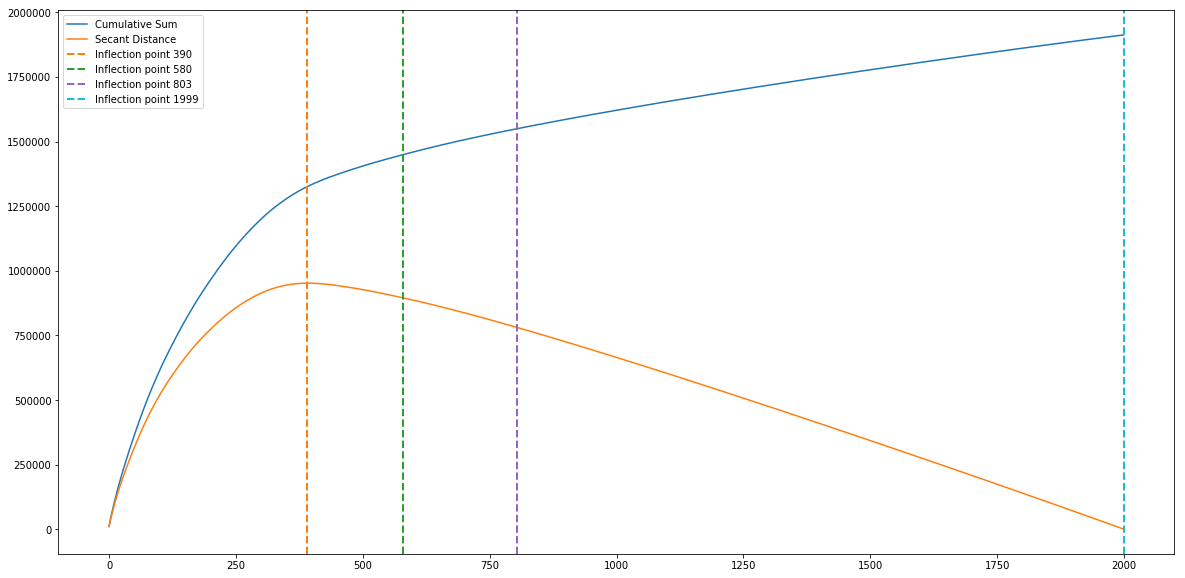

In [4]:
test_lib.find_inflection()

## Dimension_reduction for normalization, transformation, and dimensionality reduction

We pass both the library_data object and selected inflection points into the dimension_reduction object to perform our embeddings and clusterings on.

In [5]:
test_dr=dimension_reduction(test_lib,803)

The general workflow involves normalization by library size, arcsinh transformation, PCA, and then a final 2-D embedding. 

In [6]:
test_dr.lib_size_normalize() 
test_dr.arcsinh_transform() #log1p is also supported by .log1p_transform
test_dr.runPCA()
test_dr.runUMAP() #tSNE is also supported by .runTSNE

Running PCA for 100 components
Running UMAP with 10 neighbors


## Gate_visualize for visualizing gene expression, library quality, and gating by cluster

We pass both the library_data object and selected inflection points into the dimension_reduction object to perform our embeddings and clusterings on.

In [7]:
test_gate = gate_visualize(test_dr)

Now, we perform Density Peak Clustering on our 2-D embedding. The points on the decision plot represent cells that act as cluster centers, and are separated based on delta/AU and density. Delta/AU represents the distance between the current cell and any other cell with higher density values. We simply cutoffs depending on these two parameters. Generally we just want to select clusters that have higher delta/a.u. values.

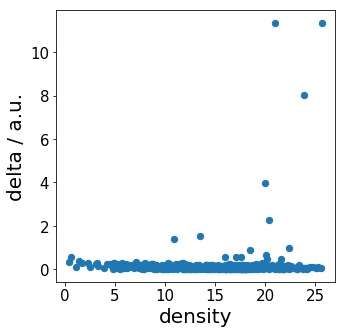

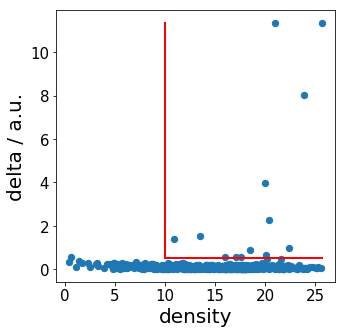

In [8]:
test_gate.runDPC(test_gate.UMAP,10,.5) #first value = density cutoff, second value = delta/a.u. cutoff

Density peak clusters are visualized and overlayed with labels. Library can also be visualized, typically low library ranks/sizes should be gated out.

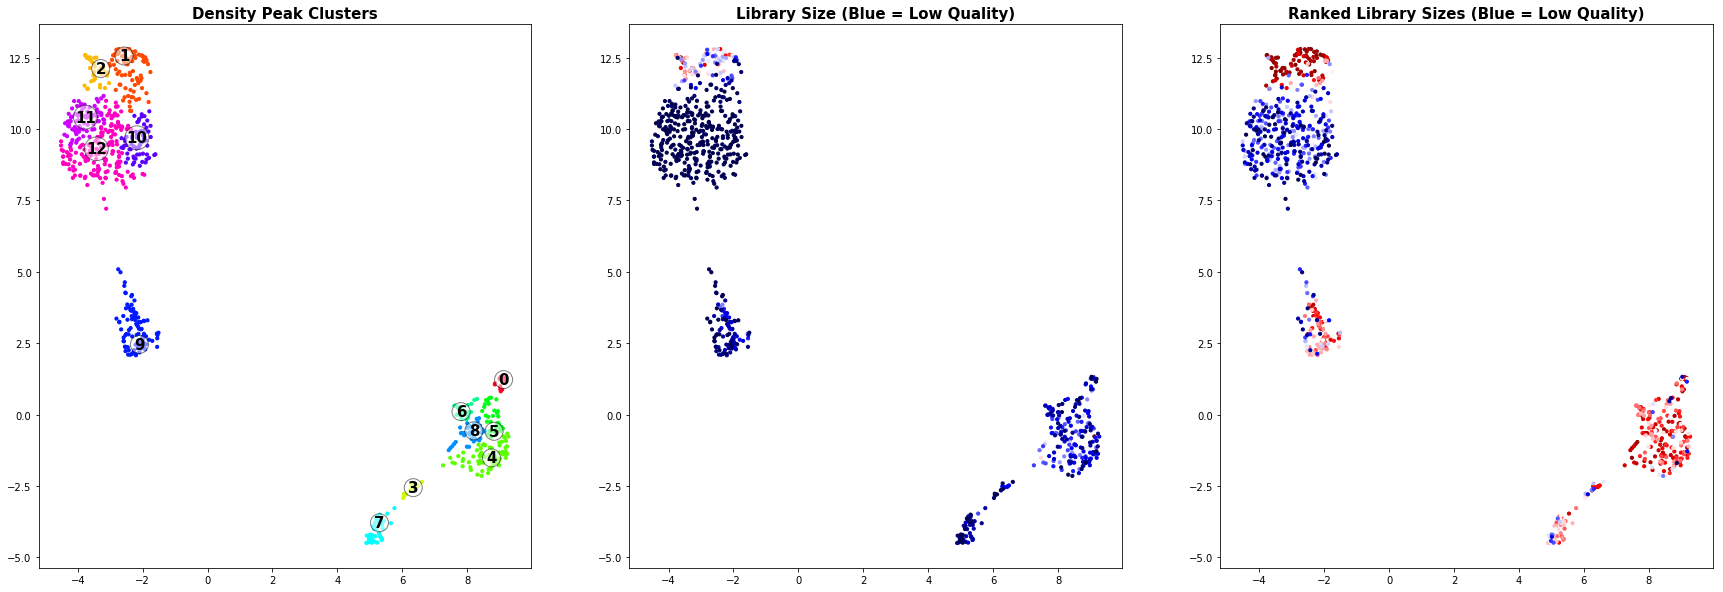

In [9]:
test_gate.plotDPC()

The visualization of certain features can be done through the .plotGenes function. A list of strings is passed into the function and used as Regex patterns. For example, "mm10_" is used to find genes designated with mouse nomenclature, the overlay will depict the sum of all features detected with the pattern per cell. A maximum of 9 features can be visualized at once.

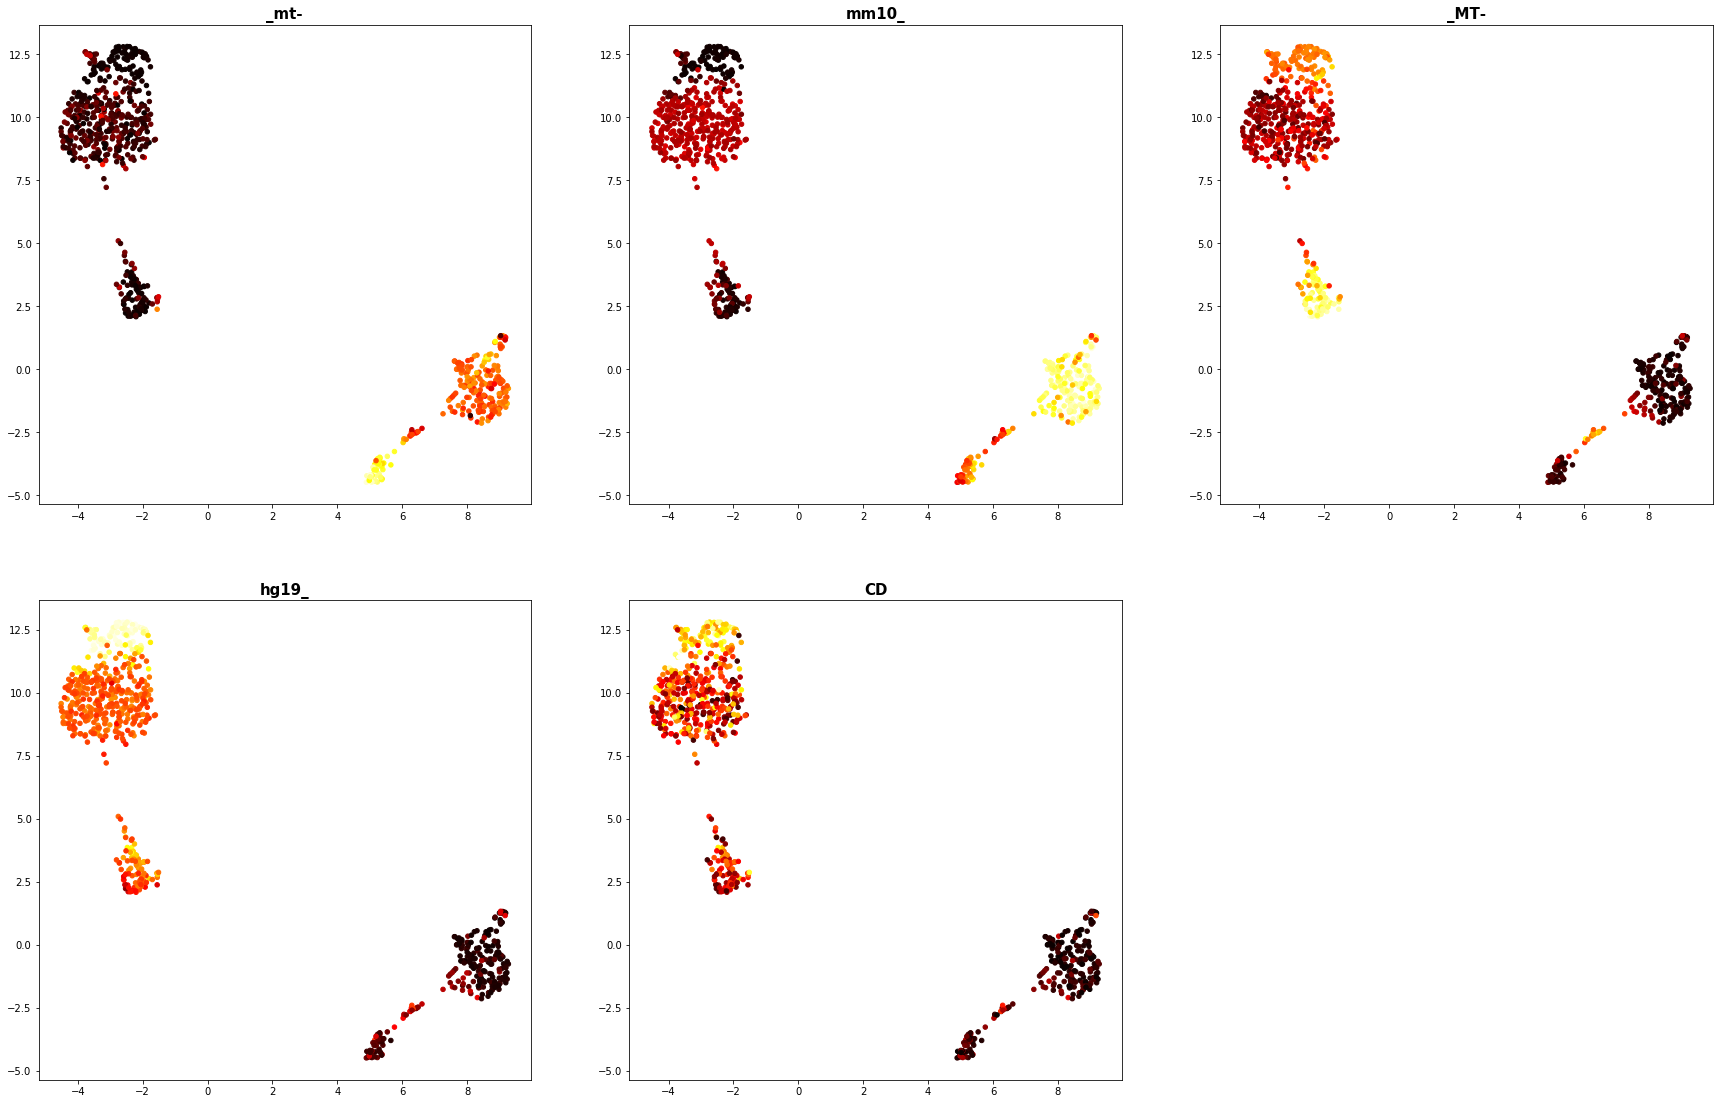

In [10]:
test_gate.plotGenes(["_mt-","mm10_","_MT-","hg19_","CD"])

Finally, we gate out clusters based on a combination of library metrics and the prior knowledge of target subpopulations. In this example, Clusters 10,11, and 12 are gated out due to their low library quality ranks. This function also returns the indices of cells after gating, which can be used to subset the original dataset for further analysis.

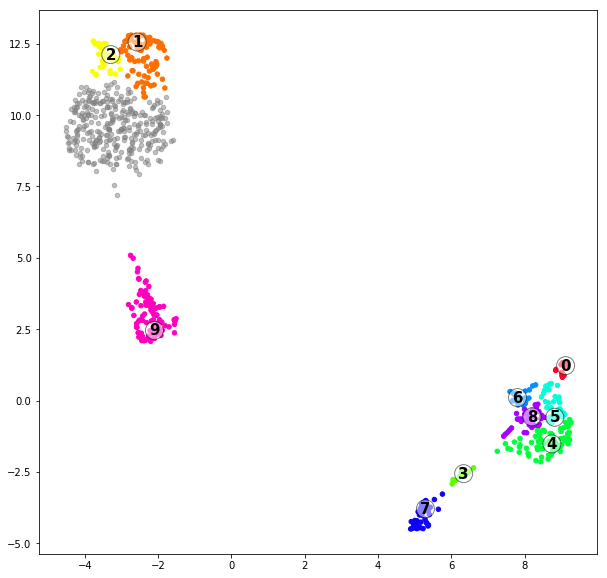

In [11]:
remaining=test_gate.manual_gating([10,11,12])

## Optional next iterations of quality control

We use the indices learned from the previous step to subset our original data so that we can further threshold library quality and gate cell subpopulations. 

In [12]:
second_run_data = test_lib.lib_counts[remaining]
second_run_cellID = test_lib.lib_cellID[remaining]

In [13]:
test_lib_second_run=library_data(second_run_data,second_run_cellID,sort=True) #It is preferable to sort the library sizes as downstream processes depend on this ordering.

Inflection point at [201 164 130 478] for [0, 15, 30, 100] percentiles of greatest secant distances


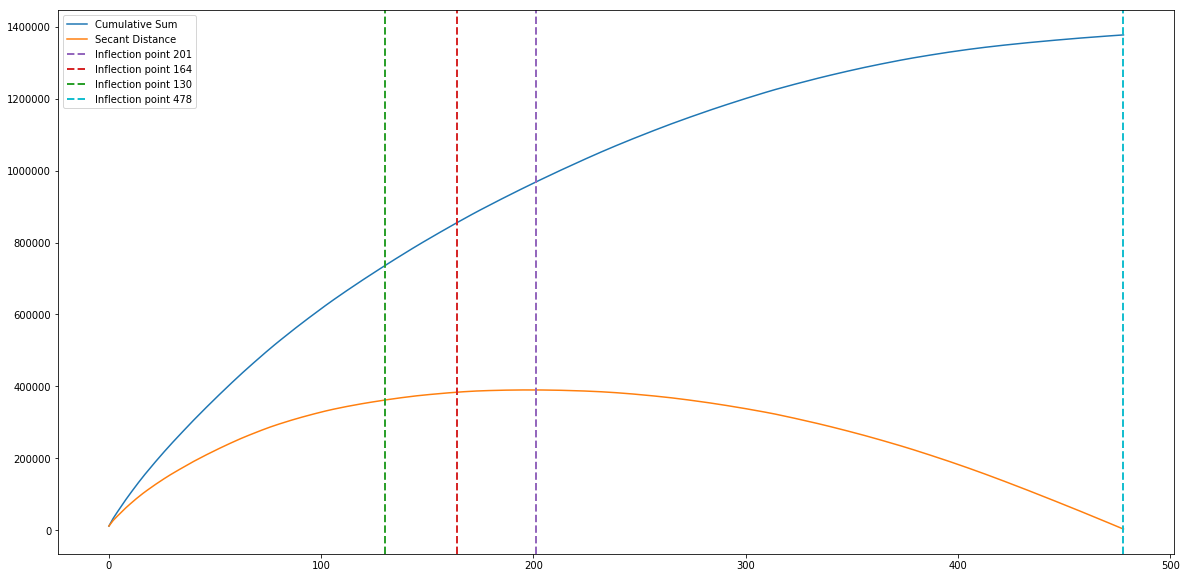

In [14]:
test_lib_second_run.find_inflection()

## Data output 

We reconstruct a pandas dataframe for a quick check of the gated data and prepare it for writing to a .csv or any other format compatible with pandas dataframes.

In [15]:
output_df = pd.DataFrame(test_lib.lib_counts[remaining].toarray())
output_df.index = test_lib.lib_cellID[remaining]
output_df.columns = test_lib.lib_geneID

In [16]:
output_df.head()

,hg19_C1QTNF1,hg19_RP11-706O15.7,mm10_Hnrnpl,hg19_ANXA5,hg19_SHMT2,mm10_mt-Nd5,mm10_Asna1,hg19_COX17,hg19_CD81,hg19_HAGH,...,hg19_C17orf112,hg19_SLC12A1,mm10_Fam83c,hg19_GPR39,hg19_AP000640.2,mm10_1600002D24Rik,hg19_RP11-950C14.7,mm10_RP24-118K20.1,hg19_HCRT,hg19_PDHA2
TAGGCTTTTGACCCTC,0,0,2,0,0,25,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
GTAAGCCGCTCCGCAT,0,0,0,2,3,1,0,5,6,1,...,0,0,0,0,0,0,0,0,0,0
GGCGACAAATCTTTGT,0,0,1,4,1,3,0,3,4,0,...,0,0,0,0,0,0,0,0,0,0
CAAACATTTGTAAAGG,0,0,0,1,0,0,0,2,2,1,...,0,0,0,0,0,0,0,0,0,0
ACCCTCAATTGGACTT,0,0,0,4,1,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
output_df.shape

(479, 34800)